## ProbDistFunc_class.py

This class takes care of the probability distribution data and methods to manipulate it.  A `ProbDistFunc` object called "`P`" is created like this:

```
P = ProbDistFunc()
```

It isn't typically necessary to create a `ProbDistFunc` object explicitly, but the class methods and variables are inherited by OptBayesExpt objects. 

### Methods

#### `P.pdf_config(self, paramvals)`
   Sets up (possibly multidimensional) arrays to represent the probability distribution function (`P.PDF` and `P.lnPDF`) and initializes them to a uniform state.  Two such arrays are set up, `ProbDistFunc.PDF` to represent the unnormalized probability distribution, and `ProbDistFunc.lnPDF` for the natural logarithm of the probability distribution.  
   
  - `paramvals` is a tuple of arrays, each containing the allowed discrete values of a parameter.  The number of arrays (i.e. the number of parameters) determines the dimensionality of the pdf array and the size of the arrays determines the size of the pdf.  Example: if paramvals contains two arrays with 15 and 38 values respectively, the pdf will be a 15 $\times$ 38 2D array.
  - `return:` None.


#### `P.set_pdf(self, flat=False, probvalarrays=[], pdf=[], lnpdf=[])`
   Sets the values of the probability distribution function.  Different arguments allow input data in four formats.

  - `flat` if True, the probability distribution will be reinitialized to a constant value, default = `False`,
  - `probvalarrays` if not empty, a tuple of 1D arrays representing the a prior distribution for each parameter.  The new pdf will be constructed as the outer product of these arrays.
  - `pdf` if not empty, a multidimensional array with dimensions corresponding to the dimensions determined during the `pdf_config()` initialization. The `P.lnPDF` values are calculated from the specified `P.PDF` values.
  - `lnpdf` same as `pdf` but with the `P.lnPDF` specified and `P.PDF` calculated.
  - `return:` None.


#### `P.add_lnpdf(self, lnlikelihood)`
   Adds its argument to `P.lnPDF`.  It is used in updating `P` with new measurement information.  It can be used to multiply the probability distributions of two `ProbDistFunc` objects `A` and `B` using `A.add_lnpdf(B.lnPDF)`.  See also `P.multiply_pdf()`. 
    
  - `lnlikelihood` A numpy array with dimensions `P.shape`.  Typically the natural log of the likelihood of obtaining a measurement result given different parameter values.
  - `return:` None.    


#### `P.multiply_pdf(self, likelihood)`
   Multiplies `P.PDF` by `likelihood`.  It is used in updating `P` with new measurement information.  It can be used to multiply the probability distributions of two `ProbDistFunc` objects `A` and `B` using `A.multiply_pdf(B.PDF)`.  See also `P.add_lnpdf()`

   - `likelihood` A numpy array with dimensions `P.shape`.  Typically the likelihood of obtaining a measurement result given different parameter values.
  - `return:` None.


#### `P.markov_draws(self)`
   Uses the Markov chain procees to generate `P.Ndraws` random draws from the parameter probability distribution.  With each call, the Markov chain process is initialized with `P.Ndraws` burn-in steps that are thrown away.
  - `return:` A numpy array with dimensions `(P.Ndraws, P.Ndims)` containing `P.Ndraws` sets of parameters.


#### `P.max_params(self)`
   This method finds the parameter values corresponding to the maximum probability in `P.lnPDF`
  - `return:` a tuple of floats containing the parameter values

#### `P.get_PDF(self, denuisance=(), normalize=True)`
   Integrates over nuisance parameters and returns a normalized probability distribution (not the log).
  - `denuisance` a tuple of integers identifying parameters to be integrated out of `P.PDF` (default none)
  - `normalize` a Boolean indicating whether to normalize the probability distribution to a sum over values = 1 (default True )
  - `return:` a numpy array with possibly reduced dimensions containing a normalized probability distribution.


#### `P.get_std(self, paraxis)`
  Computes the standard deviation of `P.PDF` collapsed down to a single axis, treating all other axes as nuisance variables.
  - `paraxis` the axis of the pdf corresponding to the vaiable of interest.
  - `return:` The standard deviation.

#### `P.get_mean(self,paraxis)`
  Computes the mean and standard deviation of `P.PDF` collapsed down to a single axis, treating all other axes as nuisance variables.
  - `paraxis` the axis of the pdf corresponding to the vaiable of interest.
  - `return:` a (mean value, standard deviation) tuple

#### `P.entropy(self):`
  Computes the information entropy of the probability distribution. Smaller values indicate narrower distributions.
  - `return:` float containting the entropy value of P.PDF.
  

### Variables

#### `P.pdfshape`
   A tuple describing the dimensions of the probability disttribution arrays.  Its value is initialized by `ProbDistFunc.pdf_config()`. 
   
#### `P.pdfdims`
   The dimensionality of P.PDF, or more simply, the number or parameters.

#### `P.PDF`
   A numpy array with dimensions `P.shape` that contains values proportional to the probaility density for the parameters.  `P.PDF` is not normalized.  See the `P.getPDF()` method to access normalized distributions.

#### `P.lnPDF`
   A numpy array with dimensions `P.shape` that contains the natural logarithm of the probability density.  `P.lnPDF` is pseudo-normalized to have a maximum value of 1.0.  See the `P.getPDF()` method to access normalized distributions.

#### `P.Ndraws`  
An integer number of random draws that will be taken from the parameter distribution during the calculation of useful settings.  Default is 200.  Initialized by `__init__()`.

#### `P.paramvals`
   A tuple of numpy arrays, stores the argument of `P.pdf_config()`


### TEST

default mypdf.shape = (101, 201)
default mypdf.lnPDF = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
default mypdf.PDF = [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
XX.shape = (101, 201)


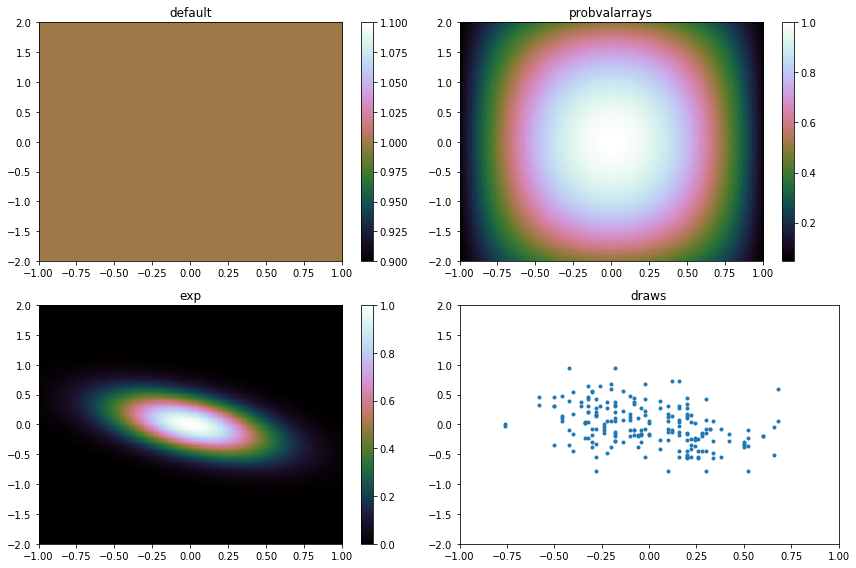

In [2]:
__author__ = 'Bob McMichael'

from ProbDistFunc_class import ProbDistFunc

import numpy as np
import matplotlib.pyplot as plt

def self_test():
    xmin, xmax, ymin, ymax = (-1, 1, -2, 2)
    extent = [xmin, xmax, ymin, ymax]

    xparam = np.linspace(xmin, xmax, 101)
    yparam = np.linspace(ymin, ymax, 201)

    #mypdf = ProbDistFunc((xparam, yparam))
    mypdf = ProbDistFunc()
    mypdf.pdf_config((xparam,yparam))

    print('default mypdf.shape = {}'.format(mypdf.pdfshape))
    print('default mypdf.lnPDF = {}'.format(mypdf.lnPDF))
    print('default mypdf.PDF = {}'.format(mypdf.PDF))

    import matplotlib.pyplot as plt

    plt.figure(figsize=(12,8))

    plt.subplot(221)
    plt.title('default')
    plt.imshow(mypdf.PDF.T, extent=extent, cmap='cubehelix', aspect='auto')
    plt.colorbar()

    plt.subplot(222)
    plt.title('probvalarrays')
    xprobs = 1 - xparam * xparam / 1.1
    yprobs = 1 - yparam * yparam / 8
    mypdf.set_pdf(probvalarrays=(xprobs, yprobs))
    plt.imshow(mypdf.PDF.T, extent=extent, cmap='cubehelix', aspect='auto')
    plt.colorbar()

    plt.subplot(223)
    plt.title('exp')
    XX, YY = np.meshgrid(xparam, yparam, indexing='ij')
    print('XX.shape = {}'.format(XX.shape))
    mypdf.set_pdf(pdf=np.exp(-(XX * XX + YY * YY + XX * YY) * 5))
    plt.imshow(mypdf.PDF.T, origin='bottom', extent=extent, cmap='cubehelix', aspect='auto')
    plt.colorbar()

    plt.subplot(224)
    plt.title('draws')
    # mydraws = mypdf.markov_draws(500)
    mydraws = mypdf.markov_draws()

    plt.scatter(mydraws[:, 0], mydraws[:, 1], marker='.')
    plt.xlim((xmin, xmax))
    plt.ylim((ymin, ymax))

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    self_test()
